In [1]:
import pandas as pd
import _background as bg
import numpy as np
import molNet
import matplotlib.pyplot as plt
import os
from rdkit import Chem
import multiprocessing
from multiprocessing import Pool, cpu_count
#import modin.pandas as pd
#import swifter

In [2]:
#from pandarallel import pandarallel
#pandarallel.initialize()

In [3]:
USE_SUBSET=True
SUBSET_SIZE=1_000_000
THREAD_COUND=max(1,int(cpu_count()-2))
STEPSIZE=int(np.ceil(SUBSET_SIZE/THREAD_COUND))#1_000_000

In [4]:
from molNet.featurizer.molecule_featurizer import (
    molecule_mol_wt,
    molecule_num_atoms,
    molecule_num_rings,
    molecule_asphericity,
)
from molNet.utils.mol.properties import has_confomers
from molNet.featurizer import molecule_featurizer
from molNet.featurizer.molecule_featurizer import *

to_ecdf={
    "molecule_mol_wt":molecule_mol_wt,
    "molecule_num_atoms":molecule_num_atoms,
    "molecule_num_rings":molecule_num_rings,
    "molecule_asphericity":molecule_asphericity,
    "molecule_autocorr2d":molecule_autocorr2d 
        }

In [5]:
from rdkit.Chem.rdMolDescriptors import CalcNumAtomStereoCenters
testmol=Chem.MolFromSmiles("c1ccccc1")
CalcNumAtomStereoCenters(testmol)
for fs,_f in molecule_featurizer._available_featurizer.items():
    if fs.startswith("molecule_"):
        to_ecdf[fs]=_f
#to_ecdf

In [6]:
SUBSET_DATA="data/CID-SMILES_subset_{}.pckl".format(SUBSET_SIZE)
FULL_DATA="data/CID-SMILES.pckl"
DATA_FOLDER="/media/julian/ex1ext4_1/temp"
MOL_FOLDER=os.path.join(DATA_FOLDER,"CID-MOLES")

VAL_DIST_FILE=os.path.join(DATA_FOLDER,"val_dist.pckl")
GLF_PARAMS_FILE=os.path.join(DATA_FOLDER,"glf_params.pckl")

os.makedirs(MOL_FOLDER,exist_ok=True)

In [7]:
def load_df():
    try:
        print("load pickle")
        dataset = pd.read_pickle(SUBSET_DATA if USE_SUBSET else FULL_DATA)
    except:
        try:
            print("load bu pickle")
            dataset = pd.read_pickle(FULL_DATA)
        except:
            print("reload textfile")
            dataset = pd.read_csv("data/CID-SMILES",sep="\t",header=None,index_col=0)
            dataset.columns=["smiles"]
            print("save bu pickle")
            dataset.to_pickle(FULL_DATA)
        if USE_SUBSET:
            dataset = dataset.sample(n = SUBSET_SIZE)
            print("save subset pickle")
            dataset.to_pickle(SUBSET_DATA)
            
            
    return dataset

In [8]:
%%time
try:
    if len(dataset)>SUBSET_SIZE or len(dataset)<SUBSET_SIZE*0.8:
        raise ValueError("wrong size")
except Exception as e:
    print(e)
    dataset = load_df()
len(dataset)

name 'dataset' is not defined
load pickle
CPU times: user 142 ms, sys: 55.2 ms, total: 198 ms
Wall time: 215 ms


1000000

In [9]:
def load_mol_file(path):
    with open(path,"rb") as f:
        mol = Chem.Mol(f.read())
    return mol

def smiles_to_molfile(smiles,uuid,path,clean=True,load_exists=True):
    fn=os.path.join(path,"{}.mol".format(uuid))
    mol=None
    change=False
    if load_exists and os.path.exists(fn):
        mol = load_mol_file(fn)
        
    if mol is None:
        mol = bg.MolFromSmiles(smiles)
        change=True
    if mol is None:
        raise ValueError("cannot generate mol")
    if clean:
        if not has_confomers(mol,iterations=0):
            change=True
            if not has_confomers(mol,iterations=1):
                if not has_confomers(mol,iterations=10):
                    raise ValueError("cannot clean")
    if change:
        with open(fn,"w+b") as f:
            f.write(mol.ToBinary())
    return mol


In [10]:
def sgar_smiles_to_molfile(arg):
    try:
        return smiles_to_molfile(*arg) is not None
    except ValueError as e:
        return False
    #except:
    #    return False
    
def batch_smiles_to_molfile(smiles,uuids,path,clean=True,processes=0,load_exist=True):
    if processes<=0:
        processes = THREAD_COUND
    print("Using {} cpu(s)".format(processes))
    data=zip(smiles,uuids,[path]*len(smiles),[clean]*len(smiles),[load_exist]*len(smiles))    
    if processes<=1:
        succs=[sgar_smiles_to_molfile(d) for d in data]
    else:        
        with Pool(processes=processes) as pool:
            res = pool.map(sgar_smiles_to_molfile,data)
            succs=res
    
    return np.array(succs,dtype=bool)

In [11]:
%%time
def clean_up(df,redo=False,check_file_exist=True):
    run_since_files_missing=False
    
    if redo or "valid" not in df.columns or df["valid"].sum()<len(df)*0.97:
        succs=batch_smiles_to_molfile(df["smiles"],df.index,MOL_FOLDER,True,processes=0,load_exist=not redo)
        df["valid"]=succs
    elif check_file_exist:
        def _c(uuid):
            return os.path.exists(os.path.join(MOL_FOLDER,"{}.mol".format(uuid)))
        e=df[df["valid"]].index.map(_c).values.astype(bool)
        fm=len(e)-e.sum()
        print(fm,"files missing")
        if fm>0:
            missingdf=df[df["valid"]].loc[~e]
            if fm<100:
                for i,d in missingdf.iterrows():
                    smiles_to_molfile(d["smiles"],i,MOL_FOLDER)
            else:
                batch_smiles_to_molfile(missingdf["smiles"],missingdf.index,MOL_FOLDER,True,processes=0,load_exist=not redo)
        

if USE_SUBSET:
    clean_up(dataset)
    dataset.to_pickle(SUBSET_DATA)

516970 files missing
Using 14 cpu(s)
CPU times: user 4.04 s, sys: 1.5 s, total: 5.54 s
Wall time: 24min 48s


In [12]:
dataset["valid"].sum()

988104

In [13]:
%%time
try:
    val_dist = pd.read_pickle(VAL_DIST_FILE)
except:
    val_dist=pd.DataFrame()

CPU times: user 22.3 s, sys: 5.78 s, total: 28.1 s
Wall time: 28.1 s


In [14]:
diffset=set(dataset[dataset["valid"]].index)-set(val_dist.index)
if len(diffset)>0:
    val_dist = val_dist.append(pd.DataFrame(index=diffset))

def iter_val_dist(df):
    j=0
    ldf=len(df)
    lj=0
    for i,d in df.iterrows():
        j+=1
        if j>lj+500:
            print("\r{}/{}     ".format(j,ldf),end="\r")
            lj=j
        missing_columns=df.columns[d.isna()]    
        mol=None
        for c in missing_columns:
            if c in to_ecdf:
                f=to_ecdf[c]
                if mol is None:
                    try:
                        mol = load_mol_file(os.path.join(MOL_FOLDER,"{}.mol".format(i)))
                    except FileNotFoundError:
                        df.drop(i,inplace=True)
                        break
                    #display(mol,Chem.MolToSmiles(mol),))
                #display(c)
                if len(Chem.rdmolops.GetMolFrags(mol)) > 1:
                       break
    #            sys.stdout.flush()
                try:
                    df.loc[i,c]=f(mol)
                except Exception as e:
                    stre=str(e)
                    if stre.startswith("ERROR: No Gasteiger Partial Charge"):
                        pass
                    elif stre.startswith("too few atoms"):
                        pass
                    elif stre.startswith("numStereoCenters called without stereo being assigned"):
                        try:
                            os.remove(os.path.join(MOL_FOLDER,"{}.mol".format(i)))
                        except:pass
                    elif stre.startswith("numUnspecifiedStereoCenters called without stereo being assigned"):
                        try:
                            os.remove(os.path.join(MOL_FOLDER,"{}.mol".format(i)))
                        except:pass
                    else:
                        #display(mol,Chem.MolToSmiles(mol))
                        print(i,e)
    return df


In [16]:
num_partitions = THREAD_COUND #number of partitions to split dataframe
val_dist_split = np.array_split(val_dist, num_partitions)


In [ ]:
with Pool(processes=THREAD_COUND) as pool:
    val_dist = pd.concat(pool.map(iter_val_dist, val_dist_split))

1478162442       Explicit valence for atom # 23 I, 7, is greater than permitted
147816244 Explicit valence for atom # 23 I, 7, is greater than permitted
5894818342       Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10 11 12 13 14

58948183 Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 8 9 10 11 12 13 14

58568652142      Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 10 11 12 13 14 15 17 19 21 22 23 24 25 26 31 32 33 34 35 36

58568652 Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 10 11 12 13 14 15 17 19 21 22 23 24 25 26 31 32 33 34 35 36

14856232842      Explicit valence for atom # 38 I, 7, is greater than permitted
148562328 Explicit valence for atom # 38 I, 7, is greater than permitted
16557821142      Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6

16557821 Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6

11722155142      Can't kekulize mol.  Unkekulized atoms: 10 24 48

11722155 Can't kekulize mol.  Unkekulized atoms: 10 24 48

35684742142      C

In [ ]:
#val_dist =iter_val_dist(val_dist)

In [ ]:
val_dist

In [ ]:
val_dist.to_pickle(VAL_DIST_FILE)
val_dist

In [46]:
df_split

NameError: name 'df_split' is not defined

In [45]:
len(val_dist)

1095696

In [59]:
val_dist

,molecule_mol_wt,molecule_num_atoms,molecule_num_rings,molecule_asphericity,molecule_autocorr2d,molecule_labute_asa,molecule_tpsa,molecule_exact_mol_wt,molecule_num_lipinski_hbd,molecule_num_lipinski_hba,...,molecule_bcut2d,molecule_get_hashed_atom_pair_fingerprint,molecule_get_hashed_topological_torsion_fingerprint,molecule_get_hashed_atom_pair_fingerprint_as_bit_vect,molecule_get_hashed_topological_torsion_fingerprint_as_bit_vect,molecule_get_maccs_keys_fingerprint,molecule_rdk_fingerprint,molecule_layered_fingerprint,molecule_pattern_fingerprint,molecule_num_bonds
17045506,[381.21299999999997],[20],[2],[0.7031936530153071],"[3.493, 3.929, 3.908, 3.665, 3.646, 3.513, 3.6...",[132.03503341734978],[38.33],[381.02257675199996],[1],[3],...,"[126.91270438182883, 10.150080039841884, 2.126...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, True, False, False, False, False, True...","[False, False, False, False, False, False, Fal...","[False, True, False, True, False, False, False...",[21]
145827843,[406.4350000000001],[29],[2],[0.2062236373799474],"[3.56, 3.92, 3.934, 3.898, 3.82, 3.817, 3.604,...",[168.8311815100274],[111.24000000000002],[406.1740011719999],[1],[9],...,"[16.56297814267458, 10.086814156243433, 2.3700...","[0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, ...","[True, True, True, False, True, False, False, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, True, True, True, False, True, False, ...","[False, False, False, False, False, False, Tru...","[False, True, False, True, False, False, False...",[30]
68455426,[264.32499999999993],[19],[2],[0.543188960839259],"[3.135, 3.392, 3.406, 3.321, 3.353, 3.101, 2.7...",[112.51413433010337],[70.59],[264.1473925],[3],[5],...,"[16.46542343403227, 10.05073635704524, 2.16716...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[True, True, True, False, True, True, True, Fa...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, True, True, False, False, False, False...","[False, False, False, False, False, False, Fal...","[False, True, False, False, False, False, Fals...",[20]
106379275,[321.33000000000004],[20],[2],[0.20014681781120905],"[3.595, 3.908, 3.887, 3.793, 3.648, 3.531, 3.2...",[117.01183127927528],[101.28999999999999],[321.005339588],[4],[6],...,"[32.23329776038929, 10.278655156259184, 2.2319...","[0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[False, False, False, False, True, True, False...","[False, False, False, False, True, False, Fals...","[False, False, False, False, False, False, Fal...","[False, False, True, True, True, False, False,...","[False, False, False, False, False, False, Fal...","[False, True, False, True, False, False, False...",[21]
97238027,[277.39300000000003],[19],[2],[0.5607229981812727],"[3.245, 3.529, 3.608, 3.344, 3.183, 3.201, 2.9...",[116.9309651629863],[57.78],[277.124883228],[2],[4],...,"[32.16649213950621, 10.237819133652327, 2.1879...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, False, False, False, False, True, False...","[False, False, True, False, False, False, Fals...","[False, True, False, True, False, False, False...",[20]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71303150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144

In [26]:
def ecdf(x,remove_steps=False):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    if remove_steps:
        xsu,uidx = np.unique(xs,return_index=True)
        for xi,idx in zip(xsu,uidx):
            ys[xs==xi]=ys[idx]
    return xs, ys

In [27]:
def glf_generator(Q,B,M,v):
    def _glf(x):
        return 1/((1+Q*np.exp(-B*(x-M)))**(1/v))
    return _glf

def glf(x,Q,B,M,v):
    return glf_generator(Q,B,M,v)(x)

In [28]:
import torch
from torch import nn

class GenLogFuncReg(nn.Module):
    def __init__(self,Q=1,B=0.1,M=0.1,v=0.1):
        super().__init__()
        self.Q = nn.Parameter(torch.Tensor([Q]))  # nn.Parameter is a Tensor that's a module parameter.
        self.B = nn.Parameter(torch.Tensor([B]))  # nn.Parameter is a Tensor that's a module parameter.
        self.M = nn.Parameter(torch.Tensor([M]))  # nn.Parameter is a Tensor that's a module parameter.
        self.v = nn.Parameter(torch.Tensor([v]))  # nn.Parameter is a Tensor that's a module parameter.
        self.reset_parameters()
        self._clean_parameter()

    def glf_parameters(self):
        return  self.Q.data.item(), self.B.data.item(), self.M.data.item(), self.v.data.item()

    def reset_parameters(self):
        return
        nn.init.normal_(self.Q,1)
        nn.init.normal_(self.B,1)
        nn.init.normal_(self.M,1)
        nn.init.normal_(self.v,1)
        self._clean_parameter()
    
    def _clean_parameter(self):
        self.v.data.clamp_(min=1e-16)
        #self.Q.data.clamp_(min=0)

        
    def forward(self, x):
        Q,B,M,v = self.Q,self.B,self.M,self.v
        return 1/((1+Q*torch.exp(-B*(x-M)))**(1/v))
        return GenLogFunc.apply(x,self.Q,self.B,self.M,self.v)
    
    def predict(self,x):
        _np=False
        if isinstance(x,np.ndarray):
            _np=True
            x = torch.from_numpy(x).float()
        y=self(x)
        if _np:
            y=y.detach().numpy()
        return y
    
    def fit(self,x,y,lr=0.1):
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        ##print(x,y)
        if isinstance(x,np.ndarray):
            x=torch.from_numpy(x).float()
        if isinstance(y,np.ndarray):
            y=torch.from_numpy(y).float()

        pre_loss=None
        d0=100
        _d=d0

        best_loss=criterion(self(x), y)
        best_vals={
            "Q":self.Q.data,
            "M":self.M.data,
            "B":self.B.data,
            "v":self.v.data,
        }
        best_epoch=-1
        for epoch in range(10000):  # loop over the dataset multiple times
            optimizer.zero_grad()
            outputs = self(x)
            loss = criterion(outputs, y)
            
            if epoch-best_epoch>d0:
                break
            
            if loss<best_loss-1e-6:
                best_loss=loss
                best_epoch = epoch
                best_vals = {
                    "Q":self.Q.data,
                    "M":self.M.data,
                    "B":self.B.data,
                    "v":self.v.data,
                }
                
            loss.backward()
            if not all(torch.isfinite(param.grad).all()  for name, param in self.named_parameters()):
                break

            optimizer.step()
            self._clean_parameter()
        self.Q.data=best_vals["Q"]
        self.M.data=best_vals["M"]
        self.B.data=best_vals["B"]
        self.v.data=best_vals["v"]
        #print(best_epoch,epoch)
        return best_loss.item()
    
def reg_nn(x,y):
    xmin=np.min(x)
    xmax=np.max(x)
    xmed=np.median(x)

    M=xmed
    if M==0:
        M=0.1
    qinia=lambda Q0: 1/(1+Q0*(np.exp((np.log((1+Q0)**np.log2(10) - 1)-np.log(Q0))*(xmax-xmed)/(xmin-xmed))))
    qinib=lambda Q0: 0.9**(np.log2(1+Q0))

    r=1000
    qx=np.linspace(-r,r,1000)
    for i in range(5):
        qy=qinia(qx)-qinib(qx)
        qm0=qm1=qm2=np.nanargmin(qy)
        if qm0>0:
            qm0=qm1-1
        if qm2<len(qx)-1:
            qm2=qm1+1
        Q=qx[qm1]
        qx=np.linspace(qx[qm0],qx[qm2],1000)

    Q=1
    v=np.log2(1+Q)
    B=(np.log((1+Q)**np.log2(10) - 1)-np.log(Q))/(xmed-xmin)

    net = GenLogFuncReg(
        Q=Q,
        B=B,
        M=M,
        v=v
    )
    r=.99
  #  print(net.glf_parameters())
    plot=False
    if plot:
        plt.plot(x,y)
        plt.plot(x,net.predict(x))
        plt.title("prefit")
        plt.show()
        plt.close()
    for s,k,lr in [(0,0.9,0.01),(0,0.95,0.01),(0,0.99,0.01),(0.0,0.99,0.001),(0.00,0.999,0.001)]:
            yl= (y<=k)#&(y>=s)
            loss=net.fit(x[yl],y[yl],lr=lr)
            if plot:
                plt.plot(x[yl],y[yl])
                plt.plot(x[yl],net.predict(x[yl]))
                plt.title("fitsampl")
                plt.show()
                plt.close()
                plt.plot(x,y)
                plt.plot(x,net.predict(x))
                plt.title("fit")
                plt.show()
                plt.close()
#            print(k,lr,loss,net.glf_parameters())
 #           plt.plot(xs,ys,label=i)
 #           plt.plot(xs,net.predict(xs),label=i)
 #           plt.show()
 #           plt.close()
    return net.glf_parameters()

In [33]:
%%time
try:
    glf_params = pd.read_pickle(GLF_PARAMS_FILE)
except:
    glf_params=pd.DataFrame(columns=["Q","B","M","v","loss"])
glf_params

CPU times: user 3.95 ms, sys: 0 ns, total: 3.95 ms
Wall time: 3.66 ms


,Q,B,M,v,loss


In [ ]:
for c in val_dist.columns[:]:
    print(c)
    i#f c=='molecule_smr_vsa_':
     #   s=False
    #if s:
    #    continue
    v = val_dist[c]
    recs=v[~v.isna()]
    
    if len(recs)==0:
        continue
    stack_data=np.stack(recs.values)
    if stack_data.shape[1] > 20:
        continue
    im=False
    for i in range(stack_data.shape[1]):
        ci="{}_{}".format(c,i)
       # if ci in glf_params.index:
       #     continue
        xs,ys=ecdf(stack_data[:,i])
        xss,yss=ecdf(stack_data[:,i],remove_steps=True)
        y_01_99= (ys<=0.99)&(ys>=0.01)
        if ci not in glf_params.index:
            glf_params=glf_params.append(pd.Series(name=ci))
            Q,B,M,v=reg_nn(xss,yss)
            glf_params.loc[ci,"Q"]=Q
            glf_params.loc[ci,"B"]=B
            glf_params.loc[ci,"M"]=M
            glf_params.loc[ci,"v"]=v
            glfy=glf(xs,Q,B,M,v)
            glf_params.loc[ci,"loss"]=((glfy-ys)**2).mean()
            glf_params.loc[ci,"loss_.01_.99"]=((glfy[y_01_99]-ys[y_01_99])**2).mean()
        im=True
        plt.plot(xs[y_01_99],ys[y_01_99],label="ECDF {}".format(i))
        ys_01_99= (yss<=ys[y_01_99].max())&(yss>=ys[y_01_99].min())
        plt.plot(xss[ys_01_99],yss[ys_01_99])

        glfx=np.linspace(xs[y_01_99].min(),xs[y_01_99].max(),200)
        glfy=glf(glfx,glf_params.loc[ci,"Q"],glf_params.loc[ci,"B"],glf_params.loc[ci,"M"],glf_params.loc[ci,"v"])
        plt.plot(glfx,glfy,label="GLF fit {}".format(i))
    
    if im:
        plt.title(c)
        plt.legend()
        plt.show()
    plt.close()
    

In [29]:
glf_params

NameError: name 'glf_params' is not defined

In [18]:
dataset[dataset["valid"]].sample(200).smiles.values.tolist()

['C1=CC=C(C=C1)C2=CC(=CC(=C2)C3=CC(=CC4=C3SC5=CC=CC=C54)N(C6=CC=CC=C6)C7=CC=CC=C7)C8=CC(=CC9=C8SC1=CC=CC=C19)N(C1=CC=CC=C1)C1=CC=CC=C1',
 'CC(C(=O)NCCN1C(=O)C=CC(=N1)N2C=CC=N2)OC3=CC(=CC=C3)Cl',
 'CCCCCC1=CC=C(C=C1)OCCCC2=C(C(=C(OC2C3=CC=C(C=C3)ON=[N+]=[N-])CCCOC4=CC=C(C=C4)CCCCC)C)CCCOC5=CC=C(C=C5)CCCCC',
 'C1CCC2=C(C1)C3=C(S2)N=C(N(C3=O)CC(=O)NC4=C(C=CC(=C4)C(F)(F)F)Cl)C5=CC=CC=C5',
 'CCCCC(CN1C(=O)C=CC1=O)O',
 'C[C@H]([C@@H](C1=N/C(=C/C2=CC(=C(C=C2)O)F)/C(=O)N1CC=O)N)O',
 'CCC1CC(CC(O1)C2=CC=C(CC2)C3=CC=C(C=C3)C4CC(=O)N4C5=CC=CC=C5)C',
 'CC[C@@H](C1=CC=NC=C1)NC(=O)C2=CSC3=NC(=CN23)C4=CC=C(C=C4)C(F)(F)F',
 'CC1(CCCCC1)/C(=C\\2/C=CC(CC2=C)CC3=CCC(C=C3)OC)/O',
 'CCCCCCCCCCCCCCCCCC(=O)OC[C@H](CO[P@](=O)(OC)OC1[C@@H]([C@H](C([C@H]([C@H]1O[C@@H]2[C@H]([C@H]([C@@H]([C@H](O2)COCC3=CC=CC=C3)OCC4=CC=CC=C4)OCC5=CC=CC=C5)OCC6=CC=CC=C6)OC(=O)C)OC(=O)C)OC(=O)C)O[C@@H]7[C@H]([C@H]([C@@H]([C@H](O7)COCC8=CC=CC=C8)OCC9=CC=CC=C9)OCC1=CC=CC=C1)OCC1=CC=CC=C1)OC(=O)CCCCCCCCCCCCCCCCC',
 'CCC1=CC(=CC=C1)N2

In [487]:


class GenLogFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx,x,Q,B,M,v):
        ctx.save_for_backward(x,Q,B,M,v)
        output = 1/((1+Q*torch.exp(-B*(x-M)))**(1/v))
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        x,Q,B,M,v = ctx.saved_tensors
        grad_x,grad_Q,grad_B,grad_M,grad_v = None,None,None,None,None
        
        exp=torch.exp(-B*(x-M))
        T1 = grad_output
        
        T2 = v*(Q*exp+1)**1/(v+1)
        
        grad_B = -T1*(Q*exp*(x-M))/T2
        grad_M = -T1*(B*Q*exp)/T2
        grad_Q = -T1*(exp)/T2
        grad_v = -T1*(torch.log(Q*exp+1))/(v**2 * (Q*exp + 1)**(1/v))

        return grad_x,grad_Q,grad_B,grad_M,grad_v



In [411]:
glf_parameter={}
glf_losses={}

In [412]:
for c in val_dist.columns:
    v = val_dist[c]
    recs=v[~v.isna()]
    if len(recs)==0:
        continue
    v=np.stack(recs.values)
    
    print(v.shape)
    if n not in glf_parameter:
        glf_parameter[n]=np.zeros((v.shape[1],4))
    if n not in glf_losses:
        glf_losses[n]=np.zeros((v.shape[1]))
        
    for i in range(v.shape[1]):
        print(n,i)
        if glf_losses[n][i] !=0:
            continue
        xs, ys = ecdf(np.array(v[:,i]))
    
        net = GenLogFuncReg()
        r=.99

        for k in [0.9,0.95,0.99,1]:
            for lr in [0.001,0.0001,0.00001]:
                loss=net.fit(xs[ys<=k],ys[ys<=k],lr=lr)
                print(k,lr,loss)
                
        glf_parameter[n][i] = net.glf_parameters()
        glf_losses[n][i] = loss
        #yp=net.predict(xs)
        #plt.plot(xs, ys, label="ecdf")
        #plt.plot(xs, yp, label="fit")
        #plt.title(n)
        #plt.legend()
        #plt.show()
        #plt.close()


        #plt.plot(xs[ys<=r], ys[ys<=r], label="ecdf")
        #plt.plot(xs[ys<=r], yp[ys<=r], label="fit")
        #plt.title(n+"99%")
        #plt.legend()
        #plt.show()
        #plt.close()
    break

(107142, 1)
molecule_mol_wt 0
[ 38.66704928  42.037       46.0781089  ... 545.602      545.602
 545.615     ] [9.33340800e-06 1.86668160e-05 2.80002240e-05 ... 8.99973866e-01
 8.99983200e-01 8.99992533e-01]
0.9 0.001 3.731121978489682e-05
[ 38.66704928  42.037       46.0781089  ... 545.602      545.602
 545.615     ] [9.33340800e-06 1.86668160e-05 2.80002240e-05 ... 8.99973866e-01
 8.99983200e-01 8.99992533e-01]
0.9 0.0001 3.6653076676884666e-05
[ 38.66704928  42.037       46.0781089  ... 545.602      545.602
 545.615     ] [9.33340800e-06 1.86668160e-05 2.80002240e-05 ... 8.99973866e-01
 8.99983200e-01 8.99992533e-01]
0.9 1e-05 3.637667396105826e-05
[ 38.66704928  42.037       46.0781089  ... 648.804      648.809
 648.809     ] [9.33340800e-06 1.86668160e-05 2.80002240e-05 ... 9.49972933e-01
 9.49982267e-01 9.49991600e-01]
0.95 0.001 3.964166535297409e-05
[ 38.66704928  42.037       46.0781089  ... 648.804      648.809
 648.809     ] [9.33340800e-06 1.86668160e-05 2.80002240e-05 ... 9

In [100]:
{
    "Q":net.Q.data,
    "M":net.M.data,
    "B":net.B.data,
    "v":net.v.data,
}

{'Q': tensor([0.5730]),
 'M': tensor([-0.4691]),
 'B': tensor([0.6872]),
 'v': tensor([0.3820])}

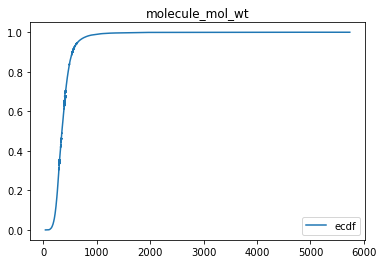

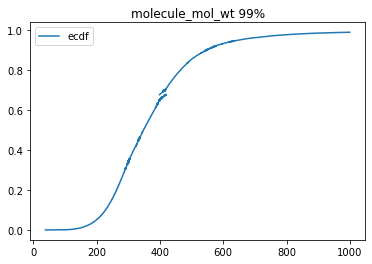

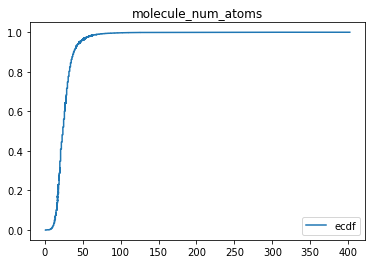

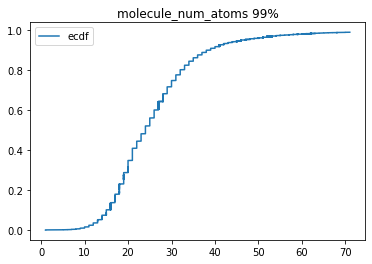

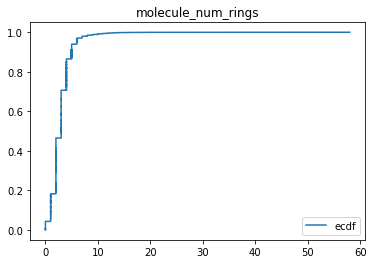

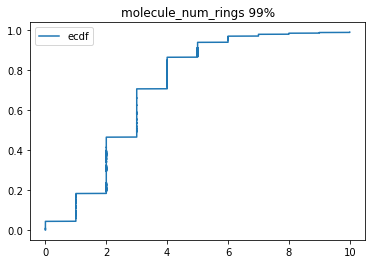

KeyboardInterrupt: 

In [529]:
for n,v in val_dist.items():
    xs, ys = ecdf(np.array(v))
    plt.plot(xs, ys, label="ecdf")
    plt.title(n)
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(xs[ys<=0.99], ys[ys<=0.99], label="ecdf")
    plt.title(n+" 99%")
    plt.legend()
    plt.show()
    plt.close()

In [500]:
glf_params

,Q,B,M,v,loss
molecule_mol_wt_0,0.036115,0.009876,346.321777,0.050291,0.000047
molecule_num_atoms_0,0.026626,0.137384,23.291618,0.035055,0.000243
molecule_num_rings_0,0.339702,0.870909,2.452087,0.363508,0.00373
molecule_asphericity_0,0.815173,5.998714,0.254061,0.387472,0.000349
molecule_labute_asa_0,0.023782,0.023856,142.03363,0.032675,0.000098
molecule_tpsa_0,0.408905,0.042672,65.633812,0.494239,0.000018
molecule_exact_mol_wt_0,NaN,NaN,NaN,NaN,NaN
molecule_num_lipinski_hbd_0,0.181556,0.952754,0.819631,0.157573,0.005538
molecule_num_lipinski_hba_0,0.554885,0.563579,4.573282,0.500081,0.001311
molecule_num_hbd_0,0.417943,1.180821,0.796131,0.340923,0.007493


In [179]:

#net.train()

array([0.12206619, 0.12206619, 0.12206619, ..., 0.87993342, 0.87993342,
       0.87993342])

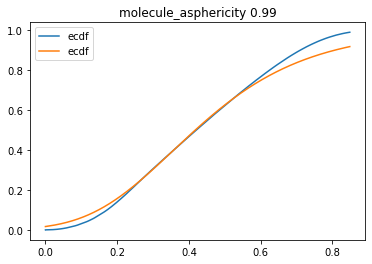

In [167]:
r=.99
plt.plot(xs[ys<=r], ys[ys<=r], label="ecdf")

yhat=net(torch.from_numpy(xs)).detach().numpy()
plt.plot(xs[ys<=r], yhat[ys<=r], label="ecdf")

plt.title(n+" "+str(r))
plt.legend()
plt.show()
plt.close()

In [52]:
dff=pd.DataFrame([{"hello":1}])
dff["j"]=[None]
dff.loc[0,["j"]]=[np.array([1,2,3]),]
dff


ValueError: Must have equal len keys and value when setting with an ndarray

In [48]:
dff.dtypes

hello     int64
j        object
dtype: object